## Init

In [1]:
from utils import get_multiberts_tokenizer
import tensorflow as tf
import tensorflow.keras.layers as tf_layers
from tqdm.auto import tqdm
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

In [2]:
num_layers = 12

In [3]:
def corr_coef(X, Y):
    muX, muY = X.mean(-1, keepdims=True), Y.mean(-1, keepdims=True) 
    X, Y = map(lambda A, mu: F.normalize(A - mu, dim=-1), [X, Y], [muX, muY])
    return X @ Y.T

In [4]:
def kernelized_corr_coef(x, y, K1, K2, K12, emb_mean1, emb_mean2, n):
    mu1, mu2 = x @ emb_mean1, y @ emb_mean2
    mu12 = torch.outer(mu1, mu2)
    x_norm, y_norm = map(lambda x, K, mu: (1/n * (x @ K) * x).sum(dim=-1) - mu**2, [x, y], [K1, K2], [mu1, mu2])
    return (1 / n * x @ K12 @ y.T - mu12) / torch.sqrt(torch.outer(x_norm, y_norm))

In [5]:
tokenizer = get_multiberts_tokenizer()

## Extract Parameters

In [6]:
multi_V = []
multi_E = []
multi_K = []
multi_WK = []
multi_WQ = []
multi_WV = []
multi_WO = []

model_paths = [f"multiberts/models/seed_{i}/bert.ckpt" for i in range(2)]
print(model_paths)

for path in tqdm(model_paths):
    multi_K.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/intermediate/dense/kernel')).T
                                      for j in range(num_layers)]))
    multi_V.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/output/dense/kernel'))
                                        for j in range(num_layers)]))    
    multi_WV.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/attention/self/value/kernel')).T
                                         for j in range(num_layers)]))
    multi_WK.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/attention/self/key/kernel')).T
                                         for j in range(num_layers)]))
    multi_WQ.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/attention/self/query/kernel')).T
                                         for j in range(num_layers)]))
    multi_WO.append(torch.cat([torch.from_numpy(tf.train.load_variable(path, 
                                            f'bert/encoder/layer_{j}/attention/output/dense/kernel'))
                                         for j in range(num_layers)]))
    multi_E.append(torch.from_numpy(tf.train.load_variable(path, "bert/embeddings/word_embeddings")).T)

['multiberts/models/seed_4/bert.ckpt', 'multiberts/models/seed_5/bert.ckpt']


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
emb1, emb2 = multi_E
# emb1, emb2 = map(lambda E: E  - E.mean(0), [emb1, emb2])

In [8]:
K1, K2 = multi_K
V1, V2 = multi_V
WK1, WK2 = multi_WK
WQ1, WQ2 = multi_WQ
WV1, WV2 = multi_WV
WO1, WO2 = multi_WO

## Parameter Alignment

In [9]:
device = 'cpu'

In [10]:
kernel11, kernel22, kernel12 = map(lambda emb1, emb2: (emb1 @ emb2.T).to(device), 
                                   [emb1, emb2, emb1], [emb1, emb2, emb2])
emb_mean1, emb_mean2 = map(lambda emb: torch.mean(emb, dim=-1), (emb1, emb2))

In [11]:
param1, param2 = WV1, WV2

In [12]:
S = kernelized_corr_coef(param1.to(device), param2.to(device), 
               kernel11.to(device), kernel22.to(device), kernel12.to(device), 
               emb_mean1.to(device), emb_mean2.to(device), n=len(tokenizer))

In [13]:
layer_size = param1.shape[0] // num_layers
S_agg = S.view(num_layers, layer_size, num_layers, layer_size).abs().mean([-1, -3]).cpu().numpy()

**Without Hungarian Algorithm**

<AxesSubplot:>

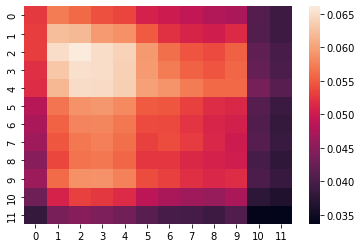

In [14]:
sns.heatmap(S_agg)

**Hungarian Algorithm Matching**

In [17]:
_, edges = linear_sum_assignment(-S_agg)

<AxesSubplot:>

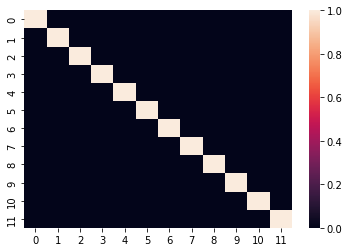

In [18]:
tmp_plot = torch.zeros(num_layers, num_layers)
tmp_plot[torch.arange(num_layers), edges] = 1
sns.heatmap(tmp_plot)

### Plot All

**Projected Vectors in Embedding Space**

  0%|          | 0/6 [00:00<?, ?it/s]

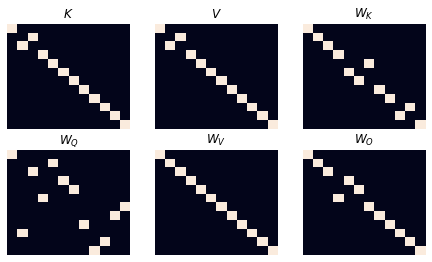

In [19]:
plt.figure(figsize=(7.5, 4.25))
for i, (title, param1, param2) in enumerate(tqdm([("$K$", K1, K2), ("$V$", V1, V2), ("$W_K$", WK1, WK2), 
                                                    ("$W_Q$", WQ1, WQ2), ("$W_V$", WV1, WV2), ("$W_O$", WO1, WO2)])):
    S = kernelized_corr_coef(param1.to(device), param2.to(device), 
                           kernel11.to(device), kernel22.to(device), kernel12.to(device), 
                           emb_mean1.to(device), emb_mean2.to(device), n=len(tokenizer))
    layer_size = param1.shape[0] // num_layers
    S_agg = S.view(num_layers, layer_size, num_layers, layer_size).abs().mean([-1, -3]).cpu().numpy()
    _, edges = linear_sum_assignment(-S_agg)
    tmp_plot = torch.zeros(num_layers, num_layers)
    tmp_plot[torch.arange(num_layers), edges] = 1
    plt.subplot(2, 3, i+1)
    plt.title(title)
    sns.heatmap(tmp_plot, cbar=False)
    plt.xticks([])
    plt.yticks([])
plt.savefig("artifacts/all_diagonals.pdf")    

**Raw Vectors in Feature Space**

  0%|          | 0/6 [00:00<?, ?it/s]

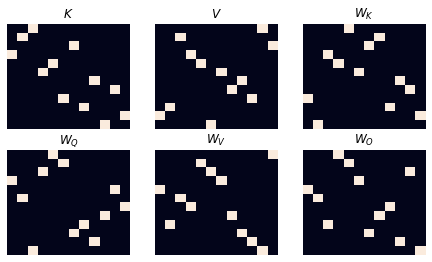

In [20]:
plt.figure(figsize=(7.5, 4.25))
for i, (title, param1, param2) in enumerate(tqdm([("$K$", K1, K2), ("$V$", V1, V2), ("$W_K$", WK1, WK2), 
                                                    ("$W_Q$", WQ1, WQ2), ("$W_V$", WV1, WV2), ("$W_O$", WO1, WO2)])):
    S = corr_coef(param1.to(device), param2.to(device))
    layer_size = param1.shape[0] // num_layers
    S_agg = S.view(num_layers, layer_size, num_layers, layer_size).abs().mean([-1, -3]).cpu().numpy()
    _, edges = linear_sum_assignment(-S_agg)
    tmp_plot = torch.zeros(num_layers, num_layers)
    tmp_plot[torch.arange(num_layers), edges] = 1
    plt.subplot(2, 3, i+1)
    plt.title(title)
    sns.heatmap(tmp_plot, cbar=False)
    plt.xticks([])
    plt.yticks([])
plt.savefig("artifacts/all_diagonals_raw.pdf")    